Notebook from curiousily:
https://github.com/curiousily/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras/blob/master/fraud_detection.ipynb

# Setup

We will be using TensorFlow 1.2 and Keras 2.0.4. Let's begin:

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["No shift", "Shift"]

Using TensorFlow backend.


# Loading the data

The dataset we're going to use can be downloaded from [Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud). It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [2]:
df = pd.read_csv("dataset.csv")

# Exploration

In [3]:
df.shape

(117164, 33)

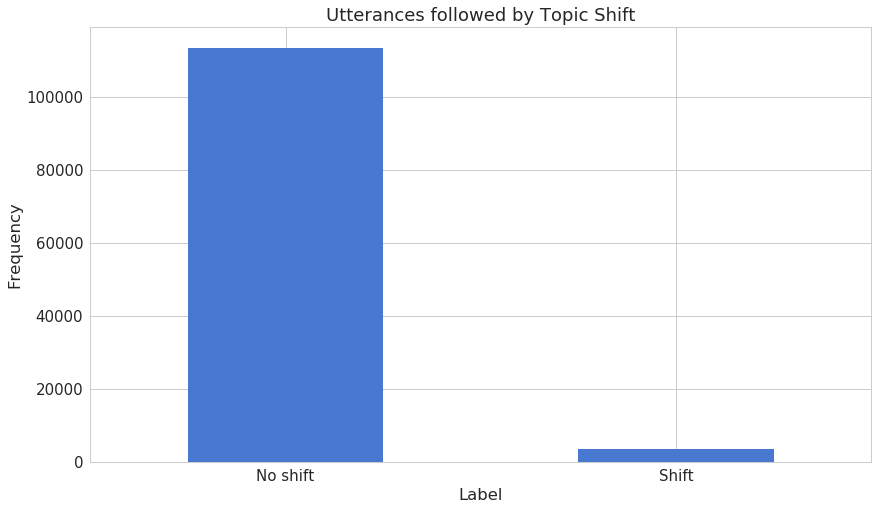

In [4]:
count_classes = pd.value_counts(df['label'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Utterances followed by Topic Shift")
plt.xticks(range(2), LABELS)
plt.xlabel("Label")
plt.ylabel("Frequency");

We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions: 

In [5]:
shifts = df[df.label == 1]
no_shifts = df[df.label == 0]

In [6]:
shifts.shape

(3629, 33)

In [7]:
no_shifts.shape

(113535, 33)

In [8]:
shifts.this_current_l.describe()

count    3629.000000
mean       11.170019
std         9.618410
min         1.000000
25%         4.000000
50%         9.000000
75%        15.000000
max        93.000000
Name: this_current_l, dtype: float64

In [9]:
no_shifts.this_current_l.describe()

count    113535.000000
mean          8.806139
std           8.146141
min           0.000000
25%           2.000000
50%           6.000000
75%          12.000000
max         100.000000
Name: this_current_l, dtype: float64

Let's have a more graphical representation:

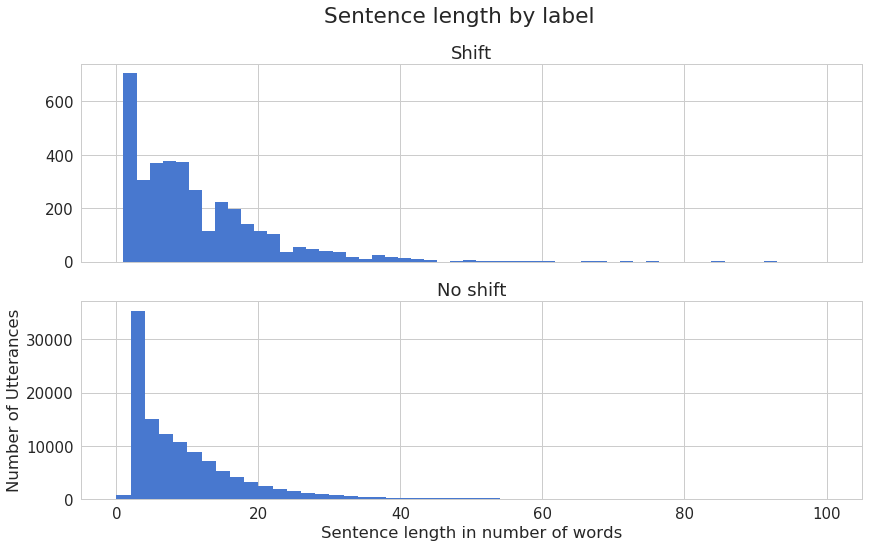

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Sentence length by label')

bins = 50

ax1.hist(shifts.this_current_l, bins = bins)
ax1.set_title('Shift')

ax2.hist(no_shifts.this_current_l, bins = bins)
ax2.set_title('No shift')

plt.xlabel('Sentence length in number of words')
plt.ylabel('Number of Utterances')
#plt.xlim((0, 20000))
#plt.yscale('log')
plt.show();

# Preparing the data

First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [11]:
from sklearn.preprocessing import StandardScaler
data = df

Training our Autoencoder is gonna be a bit different from what we are used to. Let's say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions. We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:

In [12]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.label == 0]
X_train = X_train.drop(['label'], axis=1)

y_test = X_test['label']
X_test = X_test.drop(['label'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [13]:
X_train.shape

(90820, 32)

# Building the model

Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively.  The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [14]:
input_dim = X_train.shape[1]
encoding_dim = 30

In [15]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally,  the training progress will be exported in a format that TensorBoard understands.

In [16]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 90820 samples, validate on 23433 samples
Epoch 1/100
90820/90820 [==============================] - 2s - loss: 101.8698 - acc: 0.3984 - val_loss: 63.1928 - val_acc: 0.5567
Epoch 2/100
90820/90820 [==============================] - 2s - loss: 42.5556 - acc: 0.5874 - val_loss: 28.9048 - val_acc: 0.6086
Epoch 3/100
90820/90820 [==============================] - 2s - loss: 20.5151 - acc: 0.6251 - val_loss: 15.5444 - val_acc: 0.6426
Epoch 4/100
90820/90820 [==============================] - 2s - loss: 11.9242 - acc: 0.6339 - val_loss: 10.3350 - val_acc: 0.6271
Epoch 5/100
90820/90820 [==============================] - 2s - loss: 8.4809 - acc: 0.6417 - val_loss: 7.5503 - val_acc: 0.6861
Epoch 6/100
90820/90820 [==============================] - 2s - loss: 6.6174 - acc: 0.6660 - val_loss: 6.2996 - val_acc: 0.6977
Epoch 7/100
90820/90820 [==============================] - 2s - loss: 5.6517 - acc: 0.7158 - val_loss: 5.3889 - val_acc: 0.7517
Epoch 8/100
90820/90820 [====================

90820/90820 [==============================] - 2s - loss: 0.9632 - acc: 0.8588 - val_loss: 1.0969 - val_acc: 0.8327
Epoch 65/100
90820/90820 [==============================] - 2s - loss: 0.9815 - acc: 0.8608 - val_loss: 1.6690 - val_acc: 0.8038
Epoch 66/100
90820/90820 [==============================] - 2s - loss: 0.9661 - acc: 0.8597 - val_loss: 1.3669 - val_acc: 0.8241
Epoch 67/100
90820/90820 [==============================] - 2s - loss: 0.9648 - acc: 0.8602 - val_loss: 0.9168 - val_acc: 0.8505
Epoch 68/100
90820/90820 [==============================] - 2s - loss: 0.9480 - acc: 0.8594 - val_loss: 0.9646 - val_acc: 0.8705
Epoch 69/100
90820/90820 [==============================] - 2s - loss: 0.9532 - acc: 0.8604 - val_loss: 0.9832 - val_acc: 0.8713
Epoch 70/100
90820/90820 [==============================] - 2s - loss: 0.9610 - acc: 0.8592 - val_loss: 0.9451 - val_acc: 0.8295
Epoch 71/100
90820/90820 [==============================] - 2s - loss: 0.9491 - acc: 0.8592 - val_loss: 1.9041

In [17]:
autoencoder = load_model('model.h5')

# Evaluation

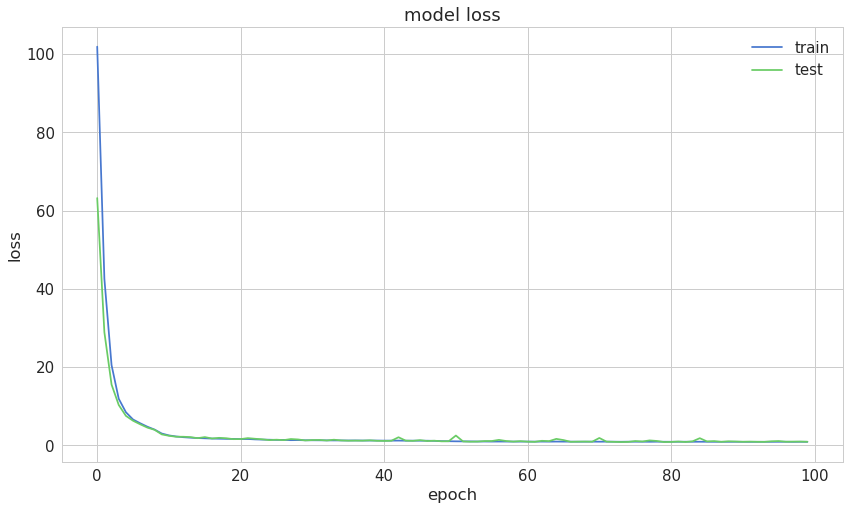

In [18]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [19]:
predictions = autoencoder.predict(X_test)

In [20]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [21]:
error_df.describe()

,reconstruction_error,true_class
count,23433.000000,23433.000000
mean,0.790215,0.030641
std,1.527725,0.172346
min,0.026228,0.000000
25%,0.188608,0.000000
50%,0.388789,0.000000
75%,0.826596,0.000000
max,45.448143,1.000000


## Reconstruction error without Topic Shifts

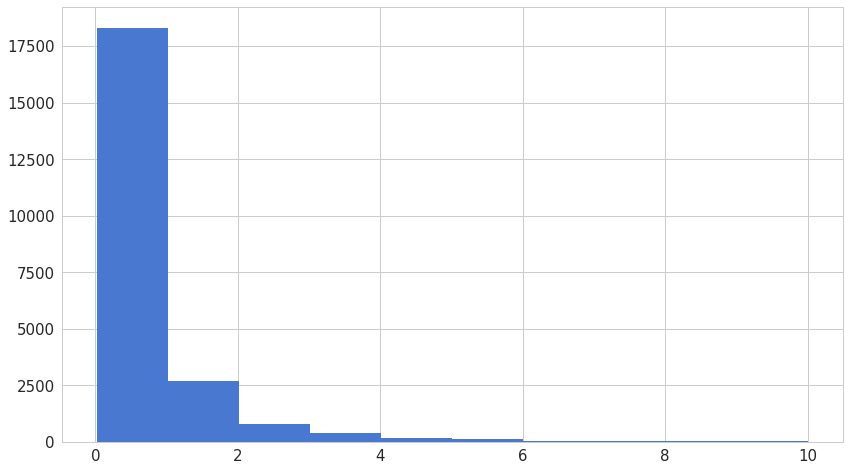

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

## Reconstruction error with Topic Shifts

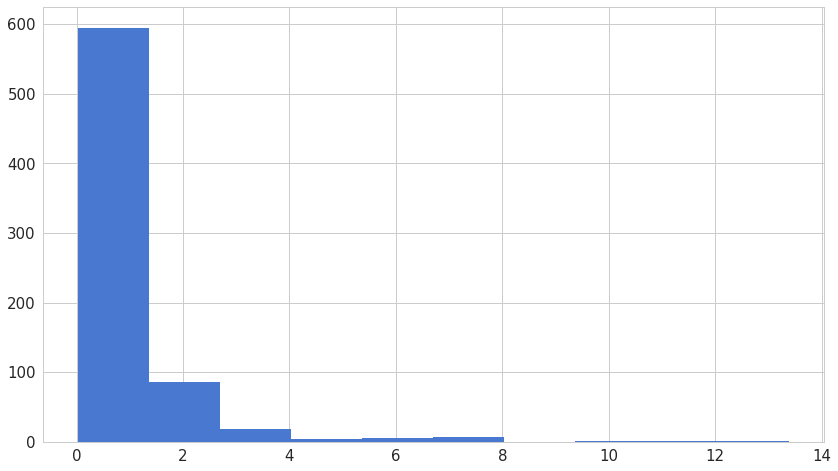

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [24]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let's have a look at our ROC curve:

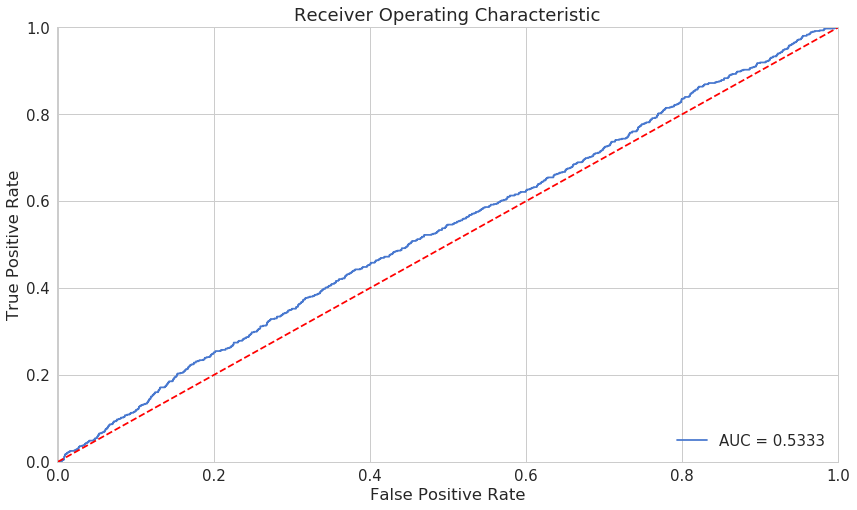

In [25]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

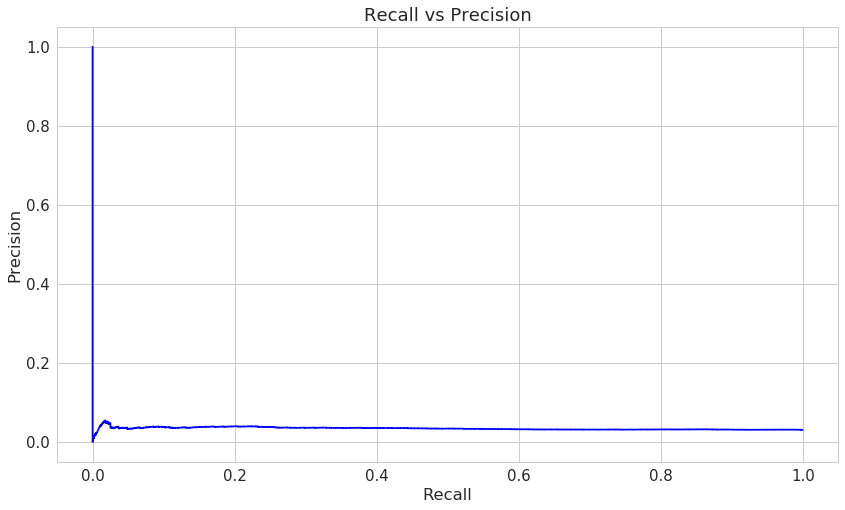

In [26]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

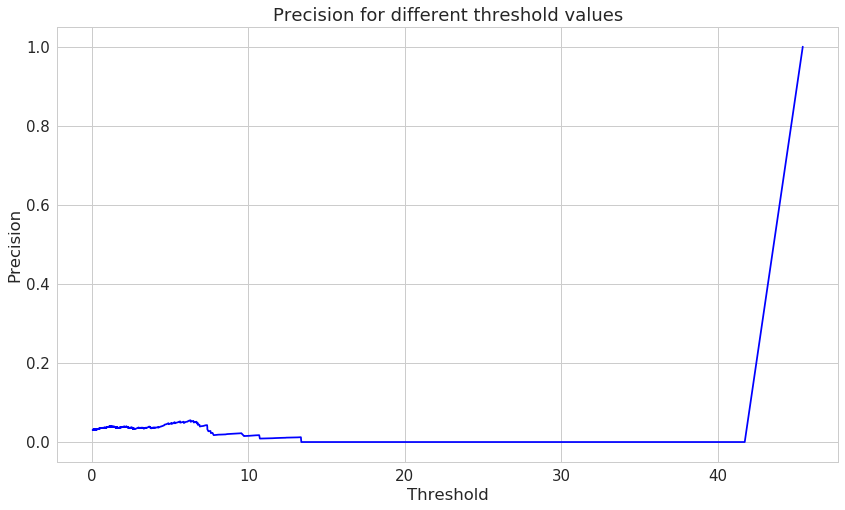

In [27]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

You can see that as the reconstruction error increases our precision rises as well. Let's have a look at the recall:

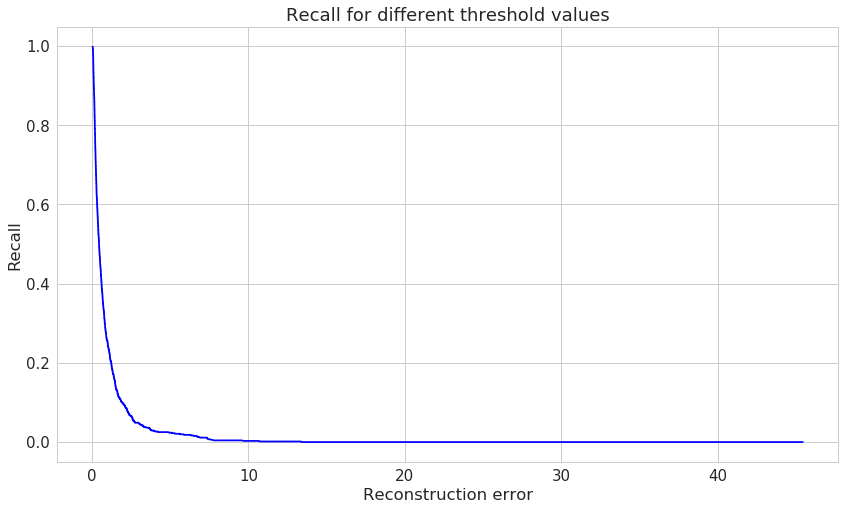

In [28]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases.

# Prediction

Our model is a bit different this time. It doesn't know how to predict new values. But we don't need that. In order to predict whether or not a new/unseen transaction is normal or fraudulent, we'll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we'll mark it as a fraud (since our model should have a low error on normal transactions). Let's pick that value:

In [38]:
threshold = 1.5

And see how well we're dividing the two types of transactions:

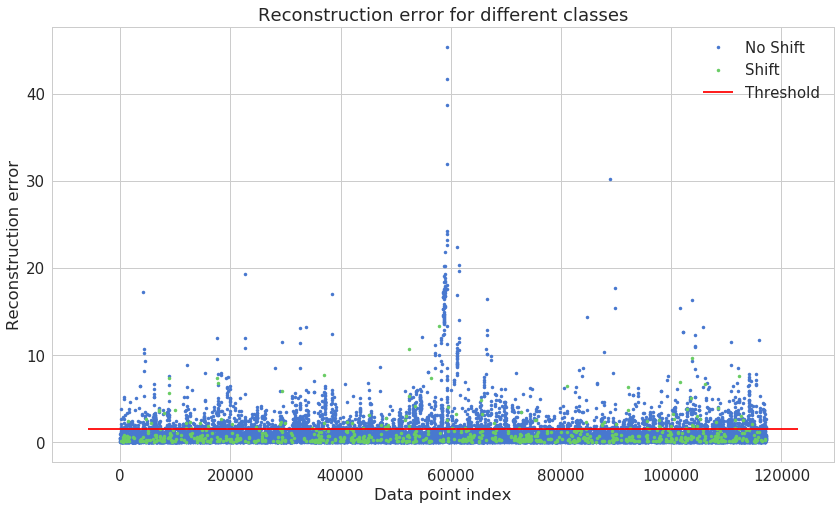

In [39]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Shift" if name == 1 else "No Shift")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

I know, that chart might be a bit deceiving. Let's have a look at the confusion matrix:

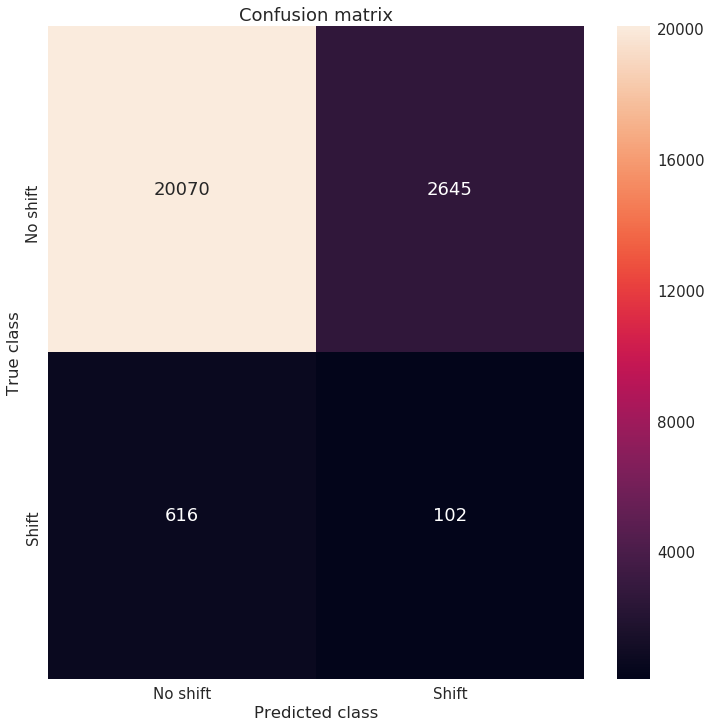

In [40]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()